<img src = "https://github.com/Jangrae/img/blob/master/parking.png?raw=true" width=800, align="left"/>

# AIVLE스쿨 2차 미니프로젝트: 신규 아파트 주차 수요 예측

# 단계 3: 모델링

## [미션]

- 모델링을 수행합니다.
    - 전처리를 추가로 진행합니다.
    - 4개 이상의 알고리즘을 사용해 모델링을 수행합니다.
    - 각 모델에 대해 성능 튜닝을 수행합니다.
    - 성능을 비교해 최선의 모델을 선정합니다.
- 데이터 파이프라인 함수를 만듭니다.
- 새로운 데이터를 읽어와 예측을 수행합니다.

## 1. 환경설정

### (1) 로컬 수행(Anaconda)

- project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [ ]:
# 기본 경로
path = ''

### (2) 구글 콜랩 수행

- 구글 콜랩을 사용중이면 구글 드라이브를 연결합니다.

In [ ]:
# 구글 드라이브 연결, 패스 지정
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/project/'

### (3) 한글 폰트 표시용 라이브러리 설치

In [ ]:
# 한글 표시를 위한 라이브러리 설치
!pip install koreanize_matplotlib -q

### (4) 라이브러리 불러오기

In [945]:
# 기본 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

# 모델링용 라이브러리 불러오기



# 기타 라이브러리 불러기기
import joblib
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format='retina'

### (5) 데이터 불러오기

- joblib.dump() 함수를 사용해 base_data2.pkl 파일을 읽어옵니다.
- 읽어온 데이터를 data 데이터프레임으로 선언하고 기본 정보를 확인합니다.

In [1375]:
row_data = pd.read_csv('df_ending_2.csv',encoding='utf-8')
row_data.shape

(1140, 30)

### (6) 함수 생성

- 실젯값과 모델이 예측한 값을 시각화해 비교할 함수를 만듭니다.

In [1382]:
# 파이프라인 만들기
def data_pipeline(data):
    apart = data.copy()

    #결측치 처리
    apart['건물형태'].fillna(apart['건물형태'].mode()[0],inplace=True)
    apart['난방방식'].fillna(apart['난방방식'].mode()[0],inplace=True)
    apart['승강기설치여부'].fillna(apart['승강기설치여부'].mode()[0],inplace=True)

    # 변수 추가
    apart['준공연도'] = apart['준공일자'].astype(str).str[:4]
    apart['준공연도'] = apart['준공연도'].astype(int)
    apart['총면적'] = (apart['전용면적'] + apart['공용면적'])*apart['전용면적별세대수']
    

    # 불필요한 변수 제거
    drop_cols = ['단지명','단지내주차면수','준공일자']
    apart.drop(columns=drop_cols,inplace=True)

    # 단지 데이터, 상세 데이터 분리
    data01 = apart.loc[:,['단지코드', '총세대수', '지역', '준공연도', '건물형태', '난방방식', '승강기설치여부', '실차량수','0-9','10월 19일','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-94','95-99','100-']]
    data01.drop_duplicates(inplace=True)
    data01.reset_index(drop=True,inplace=True)

    data02 = apart.loc[:,['단지코드', '총면적', '전용면적별세대수', '전용면적', '공용면적', '임대보증금', '임대료']]
    data02.reset_index(drop=True,inplace=True)


    # 단지 코드별 총면적 합 집계
    df_area = data02.groupby(by='단지코드')[['총면적']].sum()

    # 전용면적 구간별 집계
    bin_list = [0, 42.9, 51.97, 59.9, 68.603, 74.91, 84.083, 84.98, 139.35]
    label_list = ['면적0_42.9', '면적42.9_51.97', '면적51.97_59.9', '면적59.9_68.603', '면적68.603_74.91', '면적74.91_84.083', '면적84.083_84.98', '면적84.98_139.35']
    data02['전용면적구간'] = pd.cut(data02['전용면적'], bins = bin_list, labels = label_list)

    temp = data02.groupby(by=['단지코드','전용면적구간'])[['전용면적별세대수']].sum()
    df_pivot = temp.pivot_table(index='단지코드', columns='전용면적구간', values='전용면적별세대수', aggfunc='sum')
    df_pivot.columns.name=None
    
    # 임대보증금, 임대 평균 집계
    df_rent = data02.groupby(by='단지코드')[['임대보증금','임대료']].mean()
    
    # 집계 결과 병합
    df_area.columns = df_area.columns.str.strip()  # 공백 제거
    df_pivot.columns = df_pivot.columns.str.strip()  # 공백 제거
    base_data = df_area.merge(df_pivot,how='inner',left_index=True,right_index=True)
    base_data = base_data.merge(df_rent,how='inner', left_index=True, right_index=True)
    base_data = base_data.reset_index()

    apart = data01.merge(base_data, how='inner')

    # 난방 방식 : 개별,지역,중앙 세가지로 묶기
    nanbang_dict = {'개별가스난방': '개별', '개별유류난방': '개별', '지역난방': '지역', '지역가스난방': '지역', '지역유류난방': '지역', '중앙가스난방': '중앙', '중앙난방': '중앙', '중앙유류난방': '중앙'}
    apart['난방방식'] = apart['난방방식'].map(nanbang_dict)
    
    # 승강설치여부(0,1)
    elevator_dict = {'전체동 설치': 1, '일부동 설치': 0, '미설치': 0}
    apart['승강기설치여부'] = apart['승강기설치여부'].map(elevator_dict)


    # 단지모드, 지역변수 제거
    drop_cols = ['단지코드','지역','승강기설치여부','60-69','20-29','70-79','95-99','80-89','90-94']
    apart.drop(columns=drop_cols,inplace=True)

    # 가변수화
    dum_cols = ['건물형태','난방방식']
    apart = pd.get_dummies(apart,drop_first=True,dtype=int)

    # NaN값 채우기
    apart['0-9'].fillna(apart['0-9'].mean(),inplace=True)
    apart['10월 19일'].fillna(apart['10월 19일'].mean(),inplace=True)
    #apart['20-29'].fillna(apart['20-29'].mean(),inplace=True)
    apart['30-39'].fillna(apart['30-39'].mean(),inplace=True)
    apart['40-49'].fillna(apart['40-49'].mean(),inplace=True)
    apart['50-59'].fillna(apart['50-59'].mean(),inplace=True)
    #apart['60-69'].fillna(apart['60-69'].mean(),inplace=True)
    #apart['70-79'].fillna(apart['70-79'].mean(),inplace=True)
    #apart['80-89'].fillna(apart['80-89'].mean(),inplace=True)
    #apart['90-94'].fillna(apart['90-94'].mean(),inplace=True)
    #apart['95-99'].fillna(apart['95-99'].mean(),inplace=True)
    apart['100-'].fillna(apart['100-'].mean(),inplace=True)

    # 극이상치 최대값으로 변경
    rent_extreme_outlier = [642930.0, 586540.0, 950305.0, 573333.3333333334, 634472.5, 600352.0, 620000.0, 815355.7142857143, 744450.0, 767010.0, 759490.0, 699330.0, 600004.0, 600000.0, 580897.5, 622000.0, 715000.0, 803672.5] # 2를 모두 통일된 값으로 바꿈
    rent_min_value = min(rent_extreme_outlier)
    
    new_value = apart['임대료'][apart['임대료'] < min_value].max()
    # 특정 값들을 통일된 값으로 대체
    df_replaced = apart.replace(rent_extreme_outlier, new_value)

    rentaldeposit_extreme_outlier = [101516666.66666667, 189821857.14285713, 76513833.33333333, 114770250.0, 113172333.33333333, 100389000.0, 87417000.0, 89764000.0, 81800000.0, 96250000.0, 170746375.0, 85725000.0, 97085500.0] # 2를 모두 통일된 값으로 바꿈
    rentaldeposit_min_value = min(rentaldeposit_extreme_outlier)
    
    new_value = apart['임대보증금'][apart['임대보증금'] < rentaldeposit_min_value].max()
    # 특정 값들을 통일된 값으로 대체
    df_replaced = df_replaced.replace(rentaldeposit_extreme_outlier, new_value)

    apart = df_replaced.copy()

    return apart

## 2. 모델링

- 모델링을 위한 결측치 처리, 데이터 분할, 스케일링, 가변수화 등을 수행합니다.
- 4개 이상의 알고리즘을 사용하여 모델을 만듭니다.
- 모델 이름은 서로 다르게 합니다. (예: model1, model2...)
- Linear Regression 이외의 알고리즘을 사용한 모델은 GridSearchCV() 함수로 성능 최적화를 수행합니다.
- 적절한 평가지표로 모델의 성능을 평가합니다.
- 실젯값과 예측값을 시각화해 비교합니다.
- 성능 비교를 통해 최선의 모델을 선정합니다.

### (1) 데이터 전처리

- 필요한 전처리를 수행합니다.

In [1387]:
data = data_pipeline(row_data)

In [1389]:
data.head()

,총세대수,준공연도,실차량수,0-9,10월 19일,30-39,40-49,50-59,100-,총면적,...,면적68.603_74.91,면적74.91_84.083,면적84.083_84.98,면적84.98_139.35,임대보증금,임대료,건물형태_복도식,건물형태_혼합식,난방방식_중앙,난방방식_지역
0,78,2013,109,1288.0,2533.0,2125.0,3526.0,3293.0,0.0,6023.7683,...,0,0,0,0,56962000.0,950305.000000,0,0,0,0
1,35,2013,35,774.0,1273.0,2308.0,2842.0,3835.0,0.0,1569.1668,...,0,0,0,0,63062000.0,470100.000000,1,0,0,0
2,88,2013,88,573.0,470.0,2023.0,1517.0,2048.0,6.0,7180.1396,...,0,0,0,0,72190000.0,950305.000000,0,0,0,0
3,477,2014,943,573.0,470.0,2023.0,1517.0,2048.0,6.0,47058.9273,...,49,167,111,0,72190000.0,950305.000000,1,0,0,1
4,15,2013,21,1414.0,1677.0,6481.0,4475.0,4366.0,0.0,543.0268,...,0,0,0,0,55227500.0,340148.333333,1,0,0,0


#### 1) 가변수화

- '건물형태', '난방방식' 변수에 대해 가변수화를 수행합니다.

In [1392]:
# data = data.rename(columns={'0-9': '0-9세','10월 19일': '10-19세','20-29': '20-29세','30-39': '30-39세','40-49': '40-49세','50-59': '50-59세','60-69': '60-69세','70-79': '70-79세','80-89': '80-89세','90-94': '90-94세','95-99': '95-99세','100-': '100세 이상'})

#### 2) x, y 분리

- Target를 지정하고, x와 y로 분리합니다.

In [1395]:
# x, y 분리
target = '실차량수'
x, y = data.drop(columns=target), data[target]

#### 3) 학습용, 평가용 분리

- 학습용, 평가용 데이터를 적절한 비율로 분리합니다.

In [1398]:
# 학습용, 평가용 데이터 분리
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.2,random_state=1)

#### 4) 스케일링

- 필요한 경우 스케일링을 진행합니다.
- 예를 들어 KNN 알고리즘을 사용할 경우입니다.

In [1401]:
# 모듈 불러오기
from sklearn.preprocessing import MinMaxScaler

# 정규화
x_cols = list(x_train)
scaler = MinMaxScaler()
#scaler.fit(x_train)
x_train_s = scaler.fit_transform(x_train)

# 학습 데이터로 학습한 scaler를 그대로 사용 
x_val_s = scaler.transform(x_val)

x_train_s = pd.DataFrame(x_train_s, columns=x_cols)

In [1403]:
# 불러오기
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score, mean_absolute_error

### (1) 모델 1: KNN

In [1406]:
# 파라미터 선언
param = {'n_neighbors': range(1, 16)}

model1 = GridSearchCV(KNeighborsRegressor(),
                    param,
                    cv=5,
                    scoring='r2'
                    )
model1.fit(x_train_s,y_train)

# 변수 중요도 시각화
print(model1.best_score_)
print(model1.best_params_)

tally={}
tally['KNN'] = model1.best_score_

0.546277023209172
{'n_neighbors': 6}


### (2) 모델 2: LinearRegression

In [1443]:
# 모델링
model2 = LinearRegression(fit_intercept=False)

# 학습하기
model2.fit(x_train, y_train)

# 예측하기
y_val_pred = model2.predict(x_val)

# 평가하기
print('MAE:', mean_absolute_error(y_val, y_val_pred))
print('R2:', r2_score(y_val, y_val_pred))

tally['LinearRegression'] = r2_score(y_val, y_val_pred)

MAE: 142.34929847254523
R2: 0.7339225115804671


### (3) 모델 3: DecisionTree

In [1410]:
# 파라미터 선언
# param = {'max_depth': range(1, 21),
#         'max_leaf_nodes':range(1,11),
#         'min_samples_split':range(1,11)}

param = {'max_depth': range(1, 21)}


model3 = GridSearchCV(DecisionTreeRegressor(random_state=1),
                    param,
                    cv=5,
                    scoring='r2'
                    )
model3.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=1),
             param_grid={'max_depth': range(1, 21)}, scoring='r2')

In [1411]:
# 변수 중요도 시각화
print(model3.best_score_)
print(model3.best_params_)
tally['DecisionTreeRegressor'] = model3.best_score_

0.532128638627108
{'max_depth': 4}


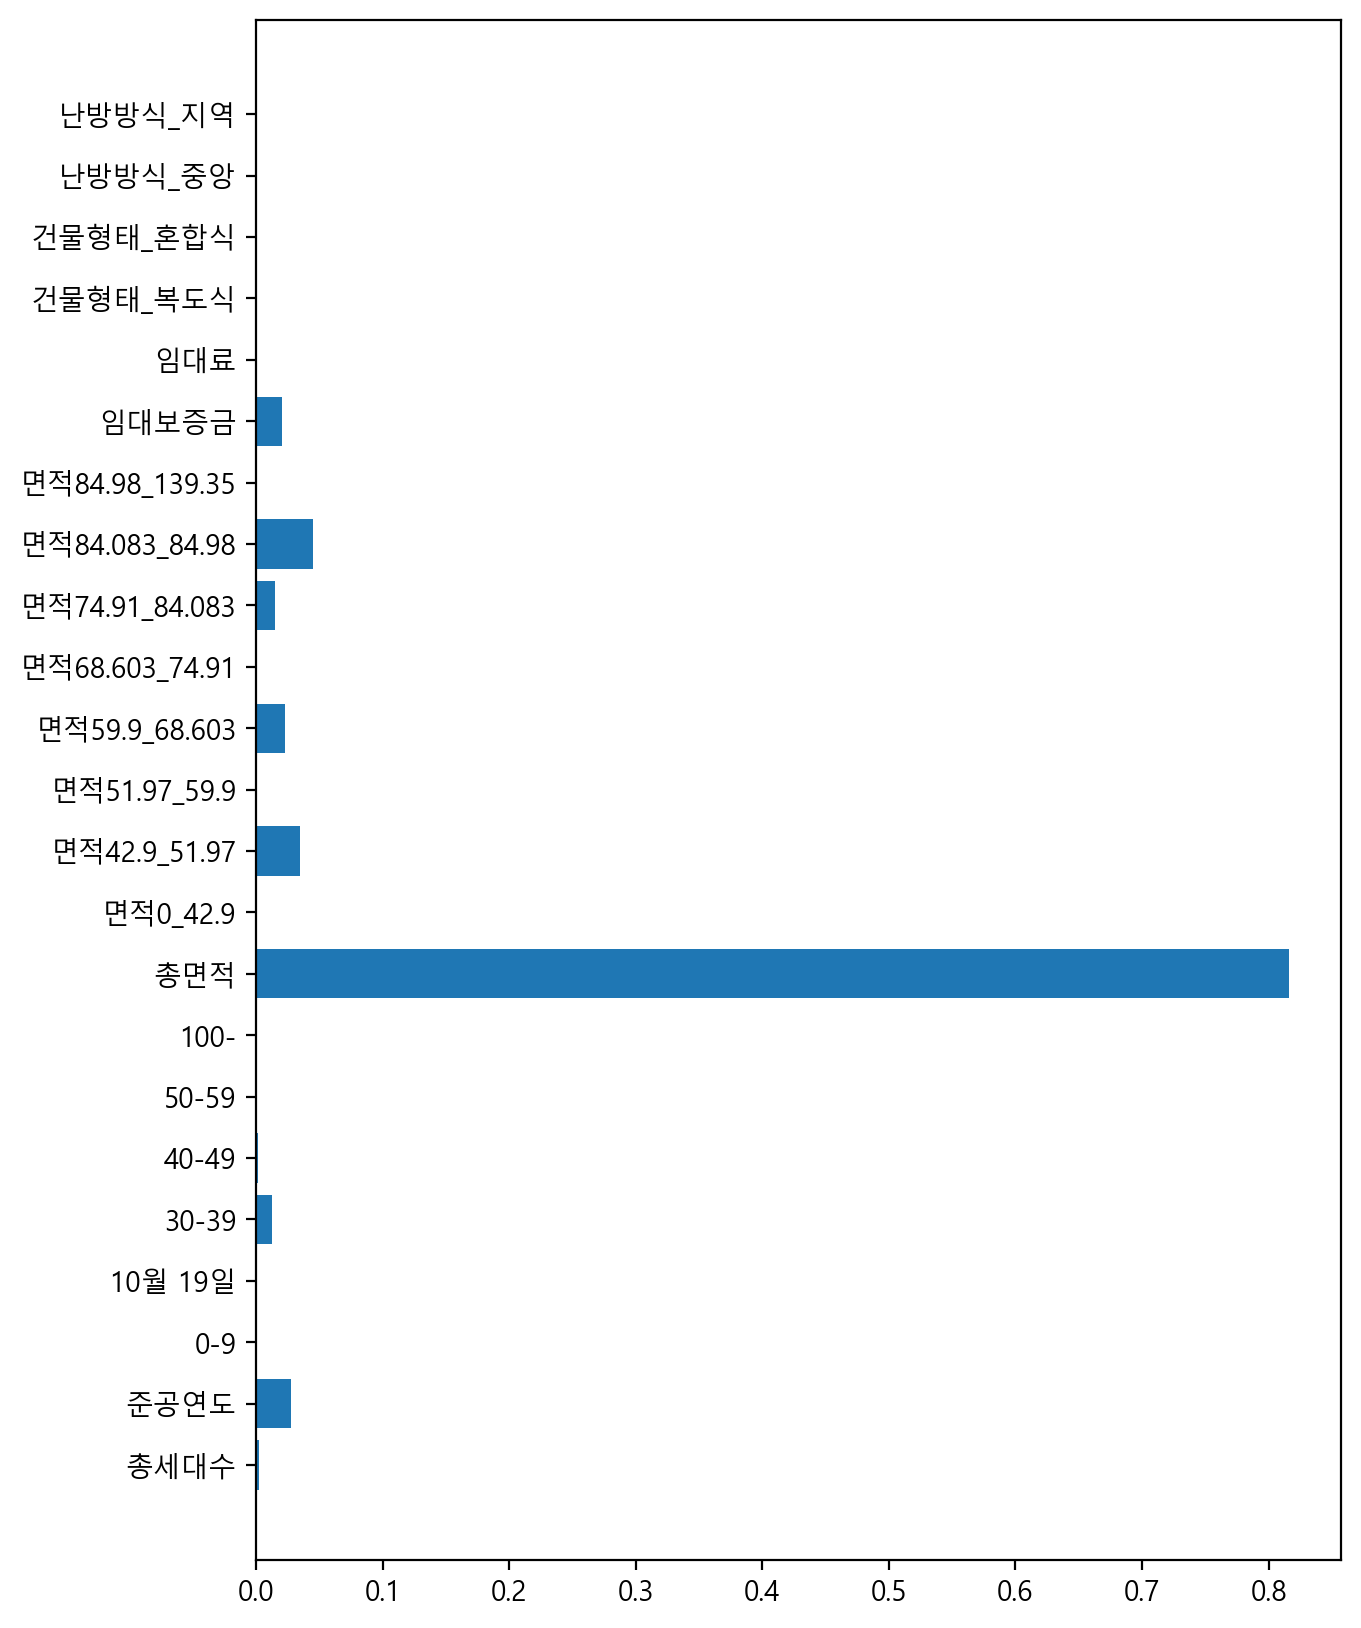

In [1412]:
plt.figure(figsize=(7,10))
plt.barh(list(x),model3.best_estimator_.feature_importances_)
plt.show()

### (4) 모델 4: RandomForest

In [1414]:
# 파라미터 선언
param = {'max_depth': range(1, 21)}

model4 = GridSearchCV(RandomForestRegressor(random_state=1),
                    param,
                    cv=5,
                    scoring='r2'
                    )
model4.fit(x_train,y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1),
             param_grid={'max_depth': range(1, 21)}, scoring='r2')

In [1415]:
# 변수 중요도 시각화
print(model4.best_params_)
print(model4.best_score_)
tally['RandomForestRegressor'] = model4.best_score_

{'max_depth': 9}
0.6875343742589761


<BarContainer object of 23 artists>

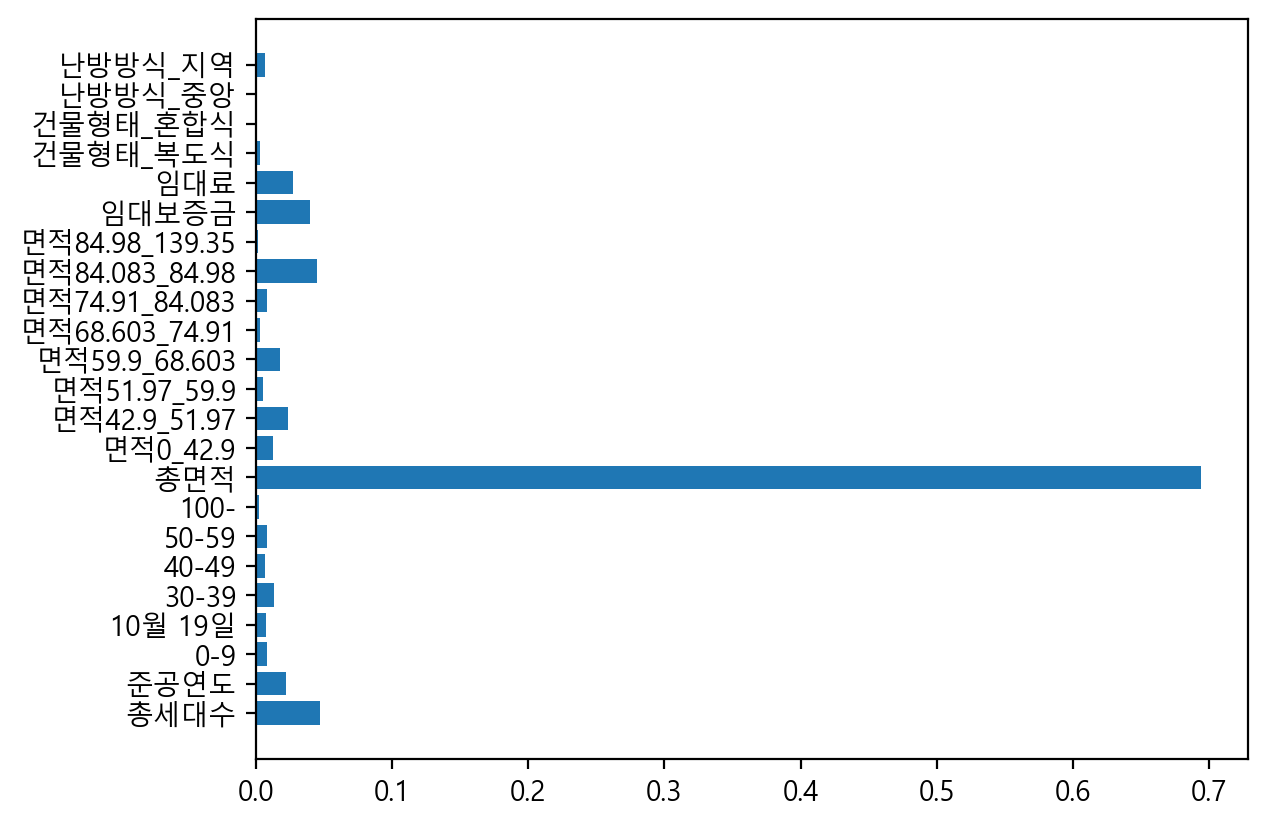

In [1416]:
plt.barh(list(x),model4.best_estimator_.feature_importances_)

### (5) 모델 5: LGB

In [1418]:
# # 파라미터 선언
# param = {'max_depth': range(1, 21),
#         'n_estimators': range(100,201,10),
#         'num_leaves':range(31,51)}

param = {'max_depth': range(1, 21)}

model5 = GridSearchCV(LGBMRegressor(verbose=-1,random_state=1),
                    param,
                    cv=5,
                    scoring='r2'
                    )
model5.fit(x_train,y_train)


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=1, verbose=-1),
             param_grid={'max_depth': range(1, 21)}, scoring='r2')

In [1419]:
# 변수 중요도 시각화
print(model5.best_params_)
print(model5.best_score_)
tally['LGBMRegressor'] = model5.best_score_

{'max_depth': 3}
0.695490923911273


<BarContainer object of 23 artists>

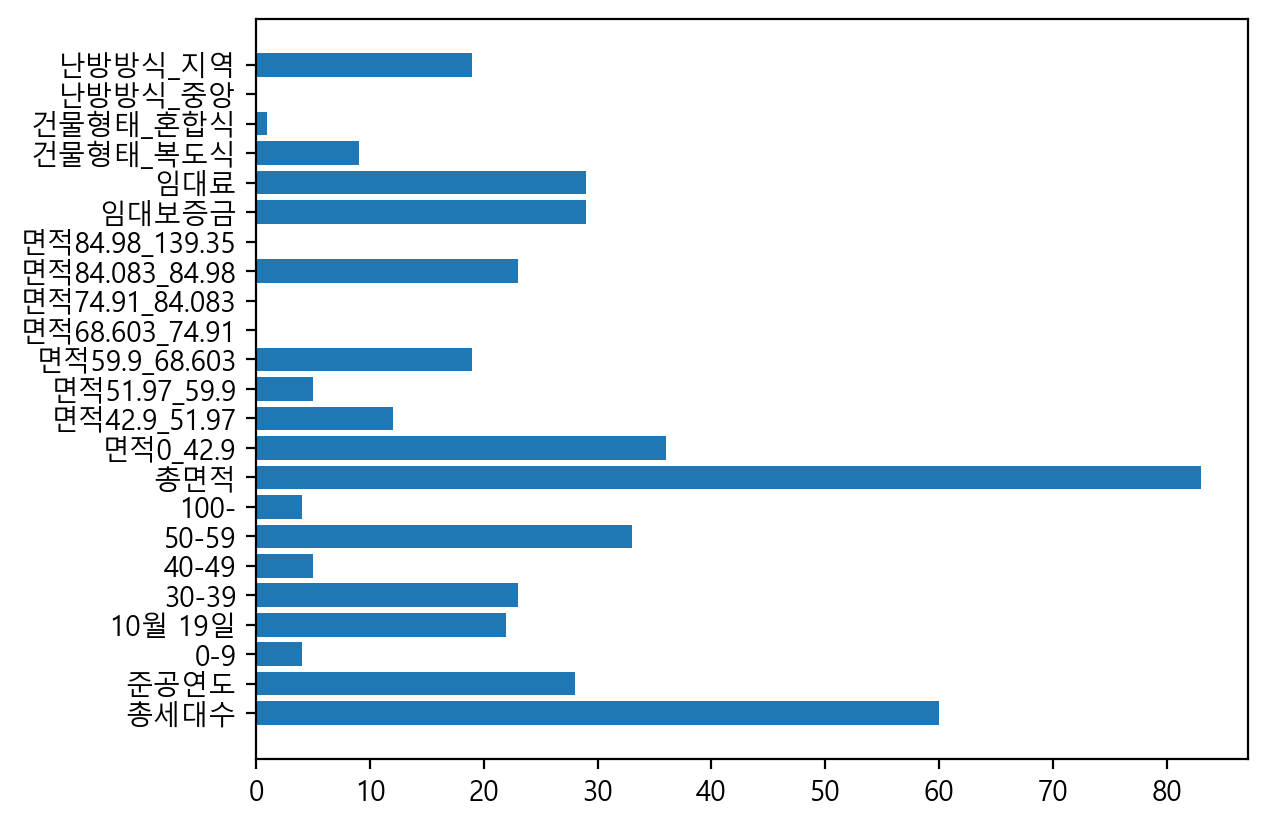

In [1420]:
plt.barh(list(x),model5.best_estimator_.feature_importances_)

### (6) 모델 6: XGBoost

In [1422]:
# 파라미터 선언
param = {'max_depth': range(1, 16)}

model6 = GridSearchCV(XGBRegressor(),
                    param,
                    cv=5,
                    scoring='r2'
                    )
model6.fit(x_train,y_train)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'max_depth': range(1, 16)}, scoring='r2')

In [1423]:
# 변수 중요도 시각화
print(model6.best_params_)
print(model6.best_score_)
tally['XGBoost'] = model6.best_score_

{'max_depth': 2}
0.6857914491672296


<BarContainer object of 23 artists>

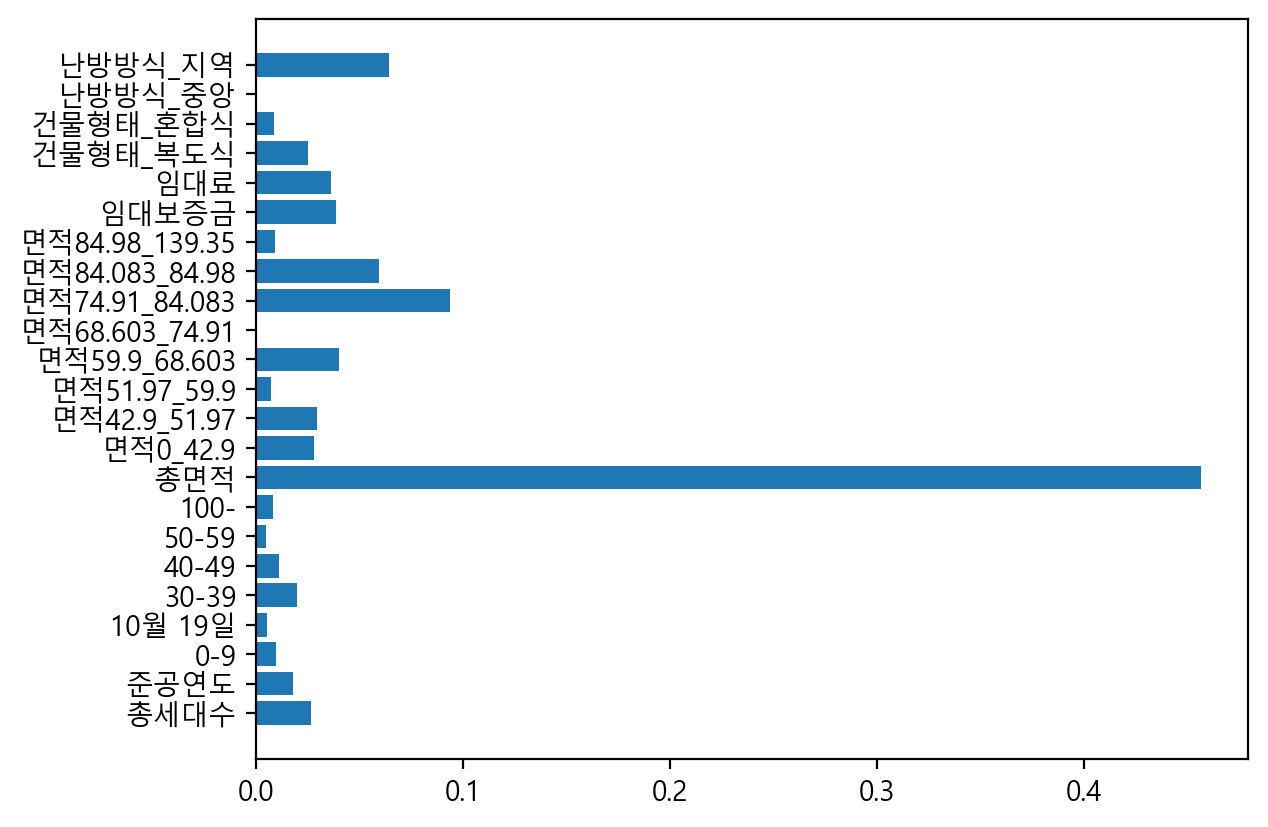

In [1424]:
plt.barh(list(x),model6.best_estimator_.feature_importances_)

### (7) 성능 비교

- 각 모델의 성능을 비교합니다.

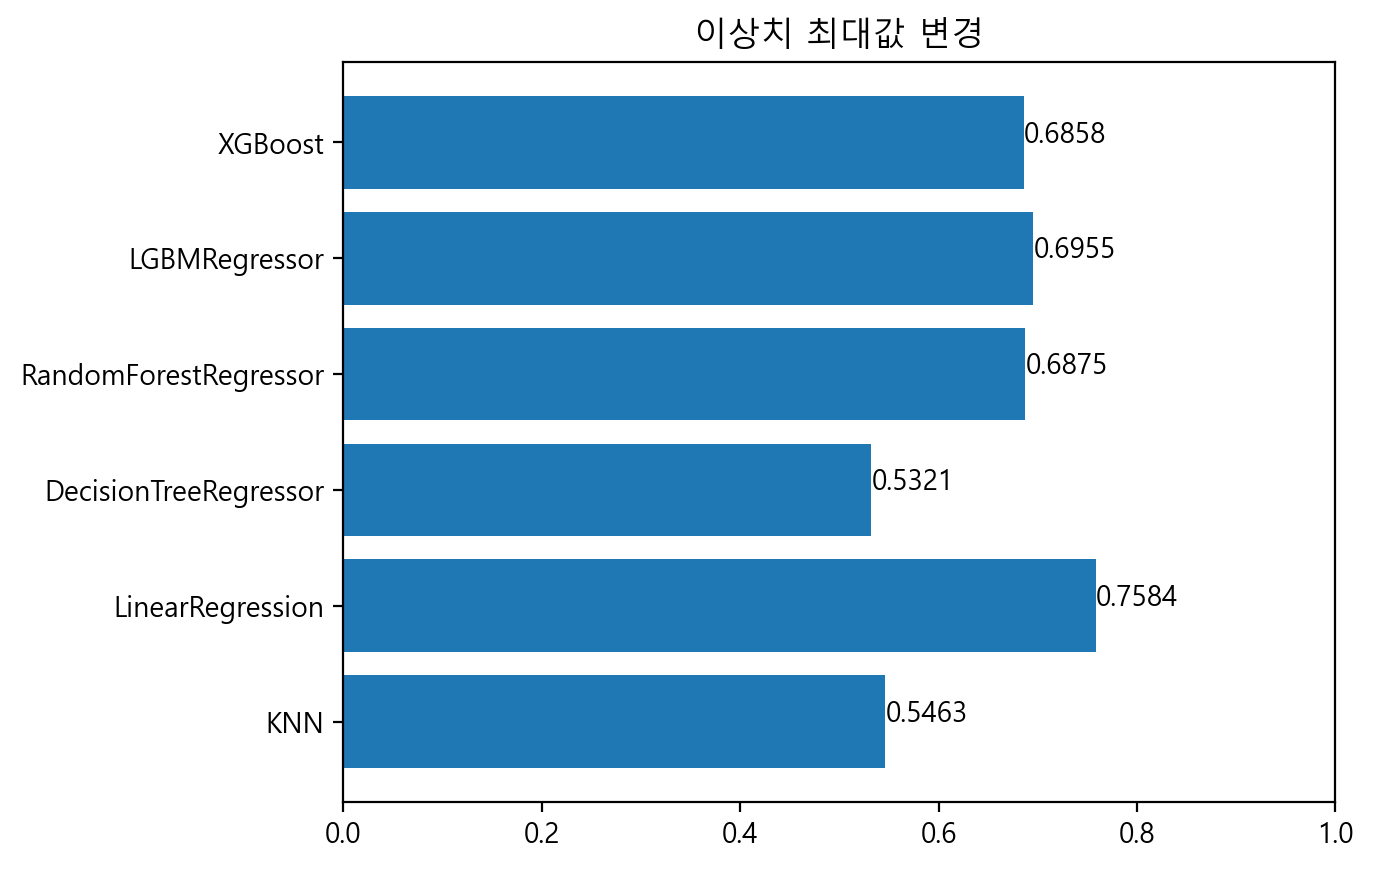

In [1426]:
plt.barh(list(tally),tally.values())

for index, value in enumerate(tally.values()):
    plt.text(value, index, str(value.round(4)))
plt.xlim(0, 1)
plt.title('이상치 최대값 변경')
plt.show()


## 3. 파이프라인 구축

- 새로운 데이터를 불러오고, 이 데이터를 처리할 파이프라인 함수를 만듭니다.

### (1) New Data 불러오기

- test.xlsx 파일을 읽어와 new_data 데이터프레임으로 선언합니다.
- 해당 데이터는 '실차량수' 변수가 없는 것 외에는, 최초 데이터와 동일한 구조입니다.
- 이 데이터를 대상으로 전처리와 예측을 수행합니다.

In [1275]:
new_data = pd.read_csv('test_add_age.csv',encoding='utf-8')
new_data.shape

(104, 29)

### (2) 데이터 파이프라인 구축

- 데이터 파이프라인 함수를 만듭니다.
- 학습 데이터에 대해 진행했던 모든 전처리 과정을 평가 데이터에도 일괄 진행해야 합니다.
    - 입력: new_data
    - 출력: 전처리가 완료된 예측 직전 데이터프레임
- 새로운 데이터에는 '실차량수' 변수가 없음을 유의합니다.
- 참고: 다음 내용들이 처리되어야 합니다.
    - 결측치 처리
    - 변수 추가
    - 불필요한 변수 제거
    - 단지 데이터, 상세 데이터 분리
    - 단지코드별 총면적 합 집계
    - 전용면적 구간별 집계 (피벗 형태)
    - 임대보증금, 임대료 평균 집계
    - 집계 결과 병합
    - 난방방식: 개별, 지역, 중앙 세 가지로 묶기
    - 승강기설치여부: 0, 1 값으로 변경
    - 단지모드, 지역 변수 제거
    - 가변수화

In [1277]:
# 파이프라인 만들기
def testdata_pipeline(data):
    apart = data.copy()

    #결측치 처리
    apart['건물형태'].fillna(apart['건물형태'].mode()[0],inplace=True)
    apart['난방방식'].fillna(apart['난방방식'].mode()[0],inplace=True)
    apart['승강기설치여부'].fillna(apart['승강기설치여부'].mode()[0],inplace=True)

    # 변수 추가
    apart['준공연도'] = apart['준공일자'].astype(str).str[:4]
    apart['준공연도'] = apart['준공연도'].astype(int)
    apart['총면적'] = (apart['전용면적'] + apart['공용면적'])*apart['전용면적별세대수']
    

    # 불필요한 변수 제거
    drop_cols = ['단지명','단지내주차면수','준공일자']
    apart.drop(columns=drop_cols,inplace=True)

    # 단지 데이터, 상세 데이터 분리
    data01 = apart.loc[:,['단지코드', '총세대수', '지역', '준공연도', '건물형태', '난방방식', '승강기설치여부','0-9','10월 19일','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-94','95-99','100-']]
    data01.drop_duplicates(inplace=True)
    data01.reset_index(drop=True,inplace=True)

    data02 = apart.loc[:,['단지코드', '총면적', '전용면적별세대수', '전용면적', '공용면적', '임대보증금', '임대료']]
    data02.reset_index(drop=True,inplace=True)


    # 단지 코드별 총면적 합 집계
    df_area = data02.groupby(by='단지코드')[['총면적']].sum()

    # 전용면적 구간별 집계
    bin_list = [0, 42.9, 51.97, 59.9, 68.603, 74.91, 84.083, 84.98, 139.35]
    label_list = ['면적0_42.9', '면적42.9_51.97', '면적51.97_59.9', '면적59.9_68.603', '면적68.603_74.91', '면적74.91_84.083', '면적84.083_84.98', '면적84.98_139.35']
    data02['전용면적구간'] = pd.cut(data02['전용면적'], bins = bin_list, labels = label_list)

    temp = data02.groupby(by=['단지코드','전용면적구간'])[['전용면적별세대수']].sum()
    df_pivot = temp.pivot_table(index='단지코드', columns='전용면적구간', values='전용면적별세대수', aggfunc='sum')
    df_pivot.columns.name=None
    
    # 임대보증금, 임대 평균 집계
    df_rent = data02.groupby(by='단지코드')[['임대보증금','임대료']].mean()
    
    # 집계 결과 병합
    df_area.columns = df_area.columns.str.strip()  # 공백 제거
    df_pivot.columns = df_pivot.columns.str.strip()  # 공백 제거
    base_data = df_area.merge(df_pivot,how='inner',left_index=True,right_index=True)
    base_data = base_data.merge(df_rent,how='inner', left_index=True, right_index=True)
    base_data = base_data.reset_index()

    apart = data01.merge(base_data, how='inner')

    # 난방 방식 : 개별,지역,중앙 세가지로 묶기
    nanbang_dict = {'개별가스난방': '개별', '개별유류난방': '개별', '지역난방': '지역', '지역가스난방': '지역', '지역유류난방': '지역', '중앙가스난방': '중앙', '중앙난방': '중앙', '중앙유류난방': '중앙'}
    apart['난방방식'] = apart['난방방식'].map(nanbang_dict)
    
    # 승강설치여부(0,1)
    elevator_dict = {'전체동 설치': 1, '일부동 설치': 0, '미설치': 0}
    apart['승강기설치여부'] = apart['승강기설치여부'].map(elevator_dict)

    # 단지모드, 지역변수 제거
    drop_cols = ['단지코드','지역']
    apart.drop(columns=drop_cols,inplace=True)

    # 가변수화
    dum_cols = ['건물형태','난방방식']
    apart = pd.get_dummies(apart,drop_first=True,dtype=int)

    # NaN값 채우기
    apart['0-9'].fillna(apart['0-9'].mean(),inplace=True)
    apart['10월 19일'].fillna(apart['10월 19일'].mean(),inplace=True)
    apart['20-29'].fillna(apart['20-29'].mean(),inplace=True)
    apart['30-39'].fillna(apart['30-39'].mean(),inplace=True)
    apart['40-49'].fillna(apart['40-49'].mean(),inplace=True)
    apart['50-59'].fillna(apart['50-59'].mean(),inplace=True)
    apart['60-69'].fillna(apart['60-69'].mean(),inplace=True)
    apart['70-79'].fillna(apart['70-79'].mean(),inplace=True)
    apart['80-89'].fillna(apart['80-89'].mean(),inplace=True)
    apart['90-94'].fillna(apart['90-94'].mean(),inplace=True)
    apart['95-99'].fillna(apart['95-99'].mean(),inplace=True)
    apart['100-'].fillna(apart['100-'].mean(),inplace=True)

    return apart

### (3) 예측하기

- new_data를 파이프라인을 사용해 전처리한 후 가장 성능이 좋았던 모델로 예측한 결과를 확인합니다.

In [1280]:
# 데이터 전처리
preprocess_data = testdata_pipeline(new_data)

# 확인
preprocess_data.shape

(32, 30)

In [1284]:
# 예측하기
predicted = model2.predict(preprocess_data)

# 확인
print(predicted)

[ 143.58669084  847.85906109  602.00082878  513.81905566  645.66165756
  250.54486127  316.98357162  493.29604353  409.47160452  428.07978808
  276.88673995  244.95513128 1300.70389365  603.99607653  302.79568276
  703.95807346  554.20221864  127.21518873 1104.35123926  953.91328571
  882.01597141  917.25803951  300.60199198  744.7948732   801.64207439
  791.99314779  899.40698458  559.49787     179.95151797 1014.44477336
  268.82082442 1174.13715496]


In [1286]:
new_data.head()

,단지코드,단지명,총세대수,전용면적별세대수,지역,준공일자,건물형태,난방방식,승강기설치여부,단지내주차면수,...,100-,0-9,10월 19일,20-29,30-39,40-49,50-59,60-69,70-79,80-89
0,C0005,서울석촌 도시형주택(공임10년),20,6,서울,20121115,복도식,개별가스난방,전체동 설치,9,...,0,1414,1677,4923,6481,4475,4366,3787,1921,612
1,C0005,서울석촌 도시형주택(공임10년),20,10,서울,20121115,복도식,개별가스난방,전체동 설치,9,...,0,1414,1677,4923,6481,4475,4366,3787,1921,612
2,C0005,서울석촌 도시형주택(공임10년),20,4,서울,20121115,복도식,개별가스난방,전체동 설치,9,...,0,1414,1677,4923,6481,4475,4366,3787,1921,612
3,C0017,대구혁신센텀힐즈,822,228,대구경북,20180221,계단식,지역난방,NaN,824,...,0,1896,4292,7307,2953,4406,4588,3526,2145,1067
4,C0017,대구혁신센텀힐즈,822,56,대구경북,20180221,계단식,지역난방,NaN,824,...,0,1896,4292,7307,2953,4406,4588,3526,2145,1067


- 아파트 기본 정보에 예측한 차량수를 붙여 마무리합니다.

In [1290]:
# 데이터 셋 두개로 나누기
vars = ['단지코드', '총세대수', '지역', '건물형태', '난방방식', '승강기설치여부','0-9','10월 19일','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-94','95-99','100-']
result = new_data[vars].copy()
result = result.drop_duplicates()
result.reset_index(drop=True, inplace=True)

# 예측 결과 추가
result['예상차량수'] = predicted.round(1).astype(int)

# 확인
result

,단지코드,총세대수,지역,건물형태,난방방식,승강기설치여부,0-9,10월 19일,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-94,95-99,100-,예상차량수
0,C0005,20,서울,복도식,개별가스난방,전체동 설치,1414,1677,4923,6481,4475,4366,3787,1921,612,62,10,0,143
1,C0017,822,대구경북,계단식,지역난방,NaN,1896,4292,7307,2953,4406,4588,3526,2145,1067,87,12,0,847
2,C0034,112,경기,계단식,지역난방,전체동 설치,3177,3278,3274,4250,5660,4987,2824,1297,643,114,33,5,602
3,C0046,122,경기,계단식,지역가스난방,전체동 설치,685,950,777,806,1489,1567,1299,493,186,18,5,0,513
4,C0055,262,경기,계단식,지역가스난방,전체동 설치,1391,2372,2088,1721,3379,3655,2070,1050,553,70,11,0,645
5,C0072,35,광주전남,계단식,개별가스난방,전체동 설치,456,825,569,615,1089,1672,2108,1900,1312,226,51,8,250
6,C0073,47,광주전남,계단식,개별가스난방,전체동 설치,4377,5295,4422,5839,7629,5133,2887,1506,816,115,24,6,317
7,C0084,152,경남,계단식,지역가스난방,전체동 설치,1387,2234,1884,1998,3372,2810,2103,755,265,22,0,0,493
8,C0085,73,경남,계단식,지역가스난방,전체동 설치,93,123,238,227,308,630,1054,688,357,59,18,0,409
9,C0112,571,경기,복도식,지역난방,전체동 설치,421,770,1353,1278,1593,2007,1799,970,498,58,11,0,428


In [1292]:
result.loc[:,['총세대수','예상차량수']]

,총세대수,예상차량수
0,20,143
1,822,847
2,112,602
3,122,513
4,262,645
5,35,250
6,47,317
7,152,493
8,73,409
9,571,428


In [1365]:
data.corr(numeric_only=True)

,총세대수,준공연도,승강기설치여부,실차량수,0-9,10월 19일,20-29,30-39,40-49,50-59,...,면적68.603_74.91,면적74.91_84.083,면적84.083_84.98,면적84.98_139.35,임대보증금,임대료,건물형태_복도식,건물형태_혼합식,난방방식_중앙,난방방식_지역
총세대수,1.000000,0.104513,0.131945,0.718729,0.180464,0.148920,0.052046,0.158481,0.161495,0.079640,...,0.060736,0.072946,-0.019589,0.071463,0.255095,0.188076,0.159322,0.158036,0.001629,0.307820
준공연도,0.104513,1.000000,0.216859,0.288545,0.050217,0.003758,-0.103810,-0.001875,-0.002738,-0.091107,...,0.155344,0.166622,0.193214,0.127314,0.361082,0.317689,-0.082572,0.007731,-0.387957,0.228081
승강기설치여부,0.131945,0.216859,1.000000,0.188360,0.045137,0.044899,0.077992,0.056597,0.032131,0.003882,...,0.025456,0.030402,0.053790,0.025991,0.122664,0.104506,0.197329,-0.021018,0.045363,0.100619
실차량수,0.718729,0.288545,0.188360,1.000000,0.266222,0.206719,0.114447,0.243426,0.225504,0.146202,...,0.192561,0.283155,0.287336,0.241869,0.376028,0.310404,-0.184732,0.108447,-0.140650,0.351400
0-9,0.180464,0.050217,0.045137,0.266222,1.000000,0.921891,0.665160,0.945921,0.958186,0.798167,...,0.178147,0.004802,0.116386,0.001434,0.074881,0.068106,-0.111875,0.138619,-0.107461,0.201256
10월 19일,0.148920,0.003758,0.044899,0.206719,0.921891,1.000000,0.789881,0.884421,0.977911,0.907376,...,0.054843,-0.007543,0.083114,0.012073,0.049930,0.026328,-0.053019,0.096204,-0.117593,0.199554
20-29,0.052046,-0.103810,0.077992,0.114447,0.665160,0.789881,1.000000,0.799498,0.775055,0.850208,...,0.017080,-0.037937,0.028985,-0.023403,0.035167,-0.010603,0.005829,0.001599,-0.081534,0.158224
30-39,0.158481,-0.001875,0.056597,0.243426,0.945921,0.884421,0.799498,1.000000,0.944033,0.852912,...,0.178112,-0.011652,0.105848,-0.011789,0.094271,0.074272,-0.068330,0.090616,-0.106010,0.212549
40-49,0.161495,-0.002738,0.032131,0.225504,0.958186,0.977911,0.775055,0.944033,1.000000,0.912182,...,0.083770,-0.007195,0.086673,0.005239,0.055286,0.037802,-0.065604,0.104418,-0.119888,0.205026
50-59,0.079640,-0.091107,0.003882,0.146202,0.798167,0.907376,0.850208,0.852912,0.912182,1.000000,...,0.007829,-0.016980,0.061094,-0.000803,0.001704,-0.010036,-0.016828,0.018843,-0.124820,0.171068


In [1368]:
# 상관관계 수치화
data = apart

corr = data.corr(numeric_only=True)
cols = list(corr)
combi = list(combinations(cols,2))

corr_values=[]
mc_list = []
tempdict={}
s=''

for com in combi:
    corr_value = corr.loc[com[0],com[1]]
    tmp = []
    
    if 0.8 < abs(corr_value) <= 1:
        s = '강한 상관관계를 가지며, 다중공선 가능성이 있다.'
        tmp.append(com[0])
        tmp.append(com[1])
        mc_list.append(tmp)
    elif 0.5 < abs(corr_value) <= 0.8:
        s = '강한 상관관계를 가진다.'
    elif 0.2 < abs(corr_value) <= 0.5:
        s = '중간의 상관관계를 가진다.'
    elif 0.1 < abs(corr_value) <= 0.2:
        s = '약한 상관관계를 가진다.'
    elif 0 < abs(corr_value) <= 0.1:
        s = '상관관계가 없다.'
    
    tempdict[f'{com[0]} - {com[1]}'] = [corr_value,s]

sorted_tempdict = dict(sorted(tempdict.items(), key=lambda item: abs(item[1][0]), reverse=True))
df = pd.DataFrame(sorted_tempdict,index=['Corr','해석']).T

display(df)

,Corr,해석
10월 19일 - 40-49,0.975659,"강한 상관관계를 가지며, 다중공선 가능성이 있다."
0-9 - 40-49,0.955019,"강한 상관관계를 가지며, 다중공선 가능성이 있다."
0-9 - 30-39,0.938041,"강한 상관관계를 가지며, 다중공선 가능성이 있다."
60-69 - 70-79,0.937089,"강한 상관관계를 가지며, 다중공선 가능성이 있다."
30-39 - 40-49,0.935828,"강한 상관관계를 가지며, 다중공선 가능성이 있다."
...,...,...
임대보증금 - 100-,0.00383,상관관계가 없다.
준공일자 - 30-39,0.003401,상관관계가 없다.
임대보증금 - 90-94,-0.003037,상관관계가 없다.
임대료 - 70-79,-0.002806,상관관계가 없다.


In [1371]:
# 실차량수만 포함하는 상관관계 수치화
df[df.index.str.contains('실차량수')]

,Corr,해석
단지내주차면수 - 실차량수,0.890446,"강한 상관관계를 가지며, 다중공선 가능성이 있다."
총세대수 - 실차량수,0.705002,강한 상관관계를 가진다.
공용면적 - 실차량수,0.349644,중간의 상관관계를 가진다.
임대보증금 - 실차량수,0.344503,중간의 상관관계를 가진다.
준공일자 - 실차량수,0.33616,중간의 상관관계를 가진다.
임대료 - 실차량수,0.326443,중간의 상관관계를 가진다.
전용면적 - 실차량수,0.313336,중간의 상관관계를 가진다.
전용면적별세대수 - 실차량수,0.296233,중간의 상관관계를 가진다.
실차량수 - 0-9,0.25544,중간의 상관관계를 가진다.
실차량수 - 30-39,0.219905,중간의 상관관계를 가진다.
